# Graph Coloring with Physics-Inspired Graph Neural Networks(GCN)

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import os.path

2.4.1+cu121
0.19.1+cu121


In [2]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
#import dgl


from time import time

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
try:
    import torch_geometric
except ImportError:
    !pip install torch_geometric
    import torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [5]:
from torch_geometric.data import Data

In [6]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [7]:
SEED_VALUE = 0           #lo richiamo anche sotto per get_gnn
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [8]:
cd /content/drive/MyDrive/FEDECOLOR

/content/drive/MyDrive/FEDECOLOR


In [9]:
ls

best_model_coloring.pth            minimal_utils_vecchiaprova3.py
data/                              minimal_utils_vecchiaprova4.py
gc_example.ipynb                   minimal_utils_vecchiaprova5_primaAttivazioneAparte.py
gc_example_prova1.ipynb            minimal_utils_vecchiaprova.py
instances.tar                      __pycache__/
minimal_utils.py                   requirements.txt
minimal_utils_vecchiaprova2.ipynb


In [10]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import os

In [11]:
from torch_geometric.nn import SAGEConv, GCNConv
from itertools import chain

In [12]:
# Known chromatic numbers for specified problems (from references)
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [13]:
def set_seed(seed):
    """
    Sets random seeds for training.

    :param seed: Integer used for seed.
    :type seed: int
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [14]:
def get_adjacency_matrix(nx_graph, torch_device, torch_dtype):
    """
    Pre-load adjacency matrix, map to torch device

    :param nx_graph: Graph object to pull adjacency matrix for
    :type nx_graph: networkx.OrderedGraph   per me cambiato con DiGraph/Graph
    :param torch_device: Compute device to map computations onto (CPU vs GPU)
    :type torch_dtype: str
    :param torch_dtype: Specification of pytorch datatype to use for matrix
    :type torch_dtype: str
    :return: Adjacency matrix for provided graph
    :rtype: torch.tensor
    """

    adj = nx.linalg.graphmatrix.adjacency_matrix(nx_graph).todense()
    adj_ = torch.tensor(adj).type(torch_dtype).to(torch_device)

    return adj_

In [15]:
def parse_line(file_line, node_offset):
    """
    Helper function to parse lines out of COLOR files - skips first character, which
    will be an "e" to denote an edge definition, and returns node0, node1 that define
    the edge in the line.

    :param file_line: Line to be parsed
    :type file_line: str
    :param node_offset: How much to add to account for file numbering (i.e. offset by 1)
    :type node_offset: int
    :return: Set of nodes connected by edge defined in the line (i.e. node_from, node_to)
    :rtype: int, int
    """

    x, y = file_line.split(' ')[1:]  # skip first character - specifies each line is an edge definition
    x, y = int(x)+node_offset, int(y)+node_offset  # nodes in file are 1-indexed, whereas python is 0-indexed (NON PENSO SIA QUESTO IL PROBLEMA)
    return x, y

In [16]:
def build_graph_from_color_file(fname, node_offset=-1, parent_fpath=''):
    """
    Load problem definition (graph) from COLOR file (e.g. *.col).

    :param fname: Filename of COLOR file
    :type fname: str
    :param node_offset: How much to offset node values contained in file
    :type node_offset: int
    :param parent_fpath: Path to prepend to `fname`
    :type parent_fpath: str
    :return: Graph defined in provided file
    :rtype: networkx.OrderedGraph === CAMBIATO con network.DiGraph
    """

    fpath = os.path.join(parent_fpath, fname)

    print(f'Building graph from contents of file: {fpath}')
    with open(fpath, 'r') as f:
        content = f.read().strip()

    # Identify where problem definition starts.
    # All lines prior to this are assumed to be miscellaneous descriptions of file contents
    # which start with "c = p".
    start_idx = [idx for idx, line in enumerate(content.split('\n')) if line.startswith('p')][0]
    lines = content.split('\n')[start_idx:]  # skip comment line(s)
    edges = [parse_line(line, node_offset) for line in lines[1:] if len(line) > 0]

    nx_temp = nx.from_edgelist(edges)

    nx_graph = nx.Graph()    #QUESTO É TUTTO, se metto DiGraph é grafo DIRETTO, sennó Undirect concettualmente é piu giusto
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))    #qua mi sa leva i link doppi, ma quando creo torch tensor non lo fa
    nx_graph.add_edges_from(nx_temp.edges)

    return nx_graph

In [17]:
#per leggere le funzioni sopra da file


#import sys
#sys.path.append('/content/drive/MyDrive/FEDECOLOR')

# Importa file come un modulo
#import minimal_utils  #nome del file sia corretto senza .py

# Step 0 - Download COLOR datasets

Uncomment the following cells to download all the COLOR datasets. This only needs to be done once.

In [18]:
# # create directory for storing input data

#input_data_path = './data/input/COLOR/instances'
#if not os.path.exists(input_data_path):
#     os.makedirs(input_data_path)

In [19]:
#!wget https://mat.tepper.cmu.edu/COLOR/instances/instances.tar -P ./data/input/COLOR/

In [20]:
#!tar -xvf ./data/input/COLOR/instances.tar -C './data/input/COLOR/instances'

# Step 1 - Set hyperparameters

We provide a default set of model hypers. Feel free to modify these as desired.

We also include general parameters such as tolerance and patience for early stopping, the layer aggregation specification (`layer_agg_type`) for GraphSAGE, and some tracking of problem definition (problem name, chromatic number).

In [21]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'queen5_5.col'

input_parent = './data/input/COLOR/instances'

In [22]:
 # Sample hyperparameters
 hypers = {
        'model': 'GNN',   # set either with GNN. It cannot take other input (lo metto dopo)      #sono quelli di GCN conv
        'dim_embedding': 64,
        'dropout': 0.1,
        'learning_rate': 0.0001,     #con weightdecay 0.01 ok                        #ragionevole a 0.01 #prima 0.0001    #(anche qua 0.001, con schedul step = 1000 e lr decay=10-3, molto fluttuante, plateau a 10)
        'hidden_dim': 64,            #prova con 0.0001 e weghtdecay=0.001 fallita
        'seed': SEED_VALUE
    }


# Default meta parameters
solver_hypers = {
    'tolerance': 1e-3,           # Loss must change by more than tolerance, or add towards patience count
    'number_epochs': int(5e4),   # Max number training steps   #non lo cambio da qui
    'patience': 500,             # Number early stopping triggers before breaking loop #non lo cambio da qui
    'graph_file': problem_file,  # Which problem is being solved
    'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
    'number_classes': chromatic_numbers[problem_file]
}

# Combine into a single set
hypers.update(solver_hypers)

# Step 2 - Load in problem and create graph

Load in problem definition from specified path. Variables `input_parent` and `problem_file` should be defined appropriately in cell 3.

In [23]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

In [24]:
# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)

# Load in graph
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

# Get DGL graph from networkx graph
# Ensure relevant objects are placed onto proper torch device
torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/queen5_5.col


In [25]:
print('torchgeom_graf=',torchgeom_graph)    #oh ok
print(torchgeom_graph.num_nodes)
print(torchgeom_graph.edge_index)

torchgeom_graf= Data(edge_index=[2, 320], num_nodes=25)
25
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 1

In [26]:
#NON SERVE

# Ordinare le righe
#edge_index_sorted, _ = torchgeom_graph.edge_index.sort(dim=0) #dovrebbe essere gia fatto
#print(edge_index_sorted)


# Rimuovere le duplicazioni
#edge_index_unique = torch.unique(torchgeom_graph.edge_index, dim=0)
#print(edge_index_unique.shape)

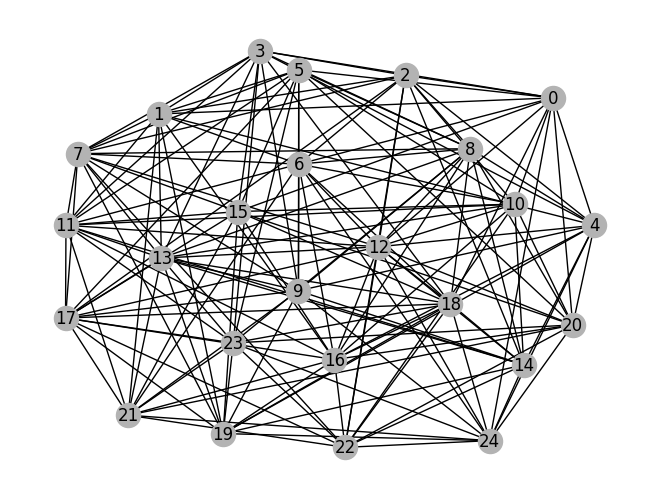

In [27]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [28]:
#creo classe della mia GNN


class GNNConv(nn.Module):
    """
    Basic GraphConv-based GNN class object. Constructs the model architecture upon
    initialization. Defines a forward step to include relevant parameters - in this
    case, just dropout.
    """
                            #self é la sua roba, g é torchgeom_graph
    def __init__(self, g, in_feats, hidden_size, num_classes, dropout):   #le in_feats diventano dim_embedding, hidden size e num_classes é da hypers
        """
        Initialize the model object. Establishes model architecture and relevant hypers (`dropout`, `num_classes`, `agg_type`)

        :param g: Input graph object
        :type g: Data of torch geometric
        :param in_feats: Size (number of nodes) of input layer
        :type in_feats: int
        :param hidden_size: Size of hidden layer
        :type hidden_size: int
        :param num_classes: Size of output layer (one node per class)
        :type num_classes: int
        :param dropout: Dropout fraction, between two convolutional layers
        :type dropout: float
        """

        super(GNNConv, self).__init__()
        self.g = g
        self.conv1 = GCNConv(in_feats, hidden_size)
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = GCNConv(hidden_size, num_classes)


    def forward(self, g):
        """
        Define forward step of netowrk. In this example, pass inputs through convolution, apply relu
        and dropout, then pass through second convolution.

        :param features: Input node representations
        :type features: torch.tensor
        :return: Final layer representation, pre-activation (i.e. class logits)
        :rtype: torch.tensor"""

        x, edge_index = g.x, g.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [29]:
print(torchgeom_graph)

Data(edge_index=[2, 320], num_nodes=25)


In [30]:
n_nodes=torchgeom_graph.num_nodes
#dim_embedding=77 #features iniziali

In [31]:
dim_embedding = hypers['dim_embedding']
hidden_dim = hypers['hidden_dim']
dropout = hypers['dropout']
number_classes = hypers['number_classes']
agg_type = hypers['layer_agg_type'] or 'mean'

print('dim embedding=',dim_embedding)

dim embedding= 64


In [32]:
embed = nn.Embedding(n_nodes, dim_embedding)    #sto creando matrice  #sarebbero le in_feat ==  dim_embedding, creo #copie di valori dei nodi pari a dim_embedding
embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)

In [33]:
embed.weight.shape   #25x64


torch.Size([25, 64])

In [34]:
data = Data(x=embed.weight, edge_index=torchgeom_graph.edge_index)
print(data.x.shape)
print(data.edge_index.shape)   #OK

torch.Size([25, 64])
torch.Size([2, 320])


In [35]:
model = hypers['model']
print(model)

GNN


In [36]:
# instantiate the GNN
print(f'Building {model} model...')
if model=='GNN':
  net = GNNConv(data, dim_embedding, hidden_dim, number_classes, dropout)      #sarebbe la mia classe che devo definire (fatto sopra)

Building GNN model...


In [37]:
print(net)

GNNConv(
  (conv1): GCNConv(64, 64)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(64, 5)
)


In [38]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

# Get adjacency matrix for use in calculations
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)

# See minimal_utils.py for description. Constructs GNN and optimizer objects from given hypers.
# Initializes embedding layer to use as initial model input
#net, embed, optimizer gia def

In [39]:
# set up Adam optimizer
params = chain(net.parameters(), embed.parameters())

print('Building ADAM-W optimizer...')
optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)            #weight_decay = decadimento esponenziale che contiene overfitting
scheduler= torch.optim.lr_scheduler.StepLR(optimizer,step_size=40000,gamma=0.9)    #AGGIUNTA IL 18/10 #step_size, ogni quante epoche il lr diminuisce del 10%(gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500)


print(optimizer)

Building ADAM-W optimizer...
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


In [40]:
# helper function for graph-coloring loss
def loss_func_mod(probs, adj_tensor):
    """
    Function to compute cost value based on soft assignments (probabilities)

    :param probs: Probability vector, of each node belonging to each class
    :type probs: torch.tensor
    :param adj_tensor: Adjacency matrix, containing internode weights
    :type adj_tensor: torch.tensor
    :return: Loss, given the current soft assignments (probabilities)
    :rtype: float
    """

    # Multiply probability vectors, then filter via elementwise application of adjacency matrix.
    #  Divide by 2 to adjust for symmetry about the diagonal
    loss_ = torch.mul(adj_tensor, (probs @ probs.T)).sum() / 2

    return loss_      #sarebbe la mia energia di potts

# helper function for custom loss according to Q matrix
def loss_func_color_hard(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph  --> da me cambiato con DiGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost_ = 0
    for (u, v) in nx_graph.edges:
        cost_ += 1*(coloring[u] == coloring[v])*(u != v)     #1 if the two nodes have the same color and are not the same node

    return cost_


In [41]:
# Ensure RNG seeds are reset each training run
seed=hypers['seed']
print(f'Start training(): Setting seed to {seed}')
#seed=1
set_seed(seed)
number_epochs=int(1e5)    #forse dovrei mettere meno
patience=500
tolerance=1e-3


# Tracking
best_cost = torch.tensor(float('Inf'))  # high initialization
best_loss = torch.tensor(float('Inf'))
best_coloring = None

# Early stopping to allow NN to train to near-completion
prev_loss = 1.  # initial loss value (arbitrary)
cnt = 0  # track number times early stopping is triggered
#count_stessicolori=0


#metto conto del tempo
t_start = time()
loss_vector_story=[]
hard_cost_vector_story=[]



# Training logic
for epoch in range(number_epochs):
    #print('epoca numero:',epoch)
    # get soft prob assignments

    logits = net(data)       #rispetto a prima net mi prende tutto il formato data

    # apply softmax for normalization
    probs = F.softmax(logits, dim=1)       #qua dovrebbe normalizzare
    #print('probs=',probs)   #print(probs.shape)========esce 25x5 (sarebbero le 5 prob dei 5 colori per ogni nodo, poi devo prendere quella maggiore)

    # get cost value with POTTS cost function
    loss = loss_func_mod(probs, adj_)              #calcolo la loss con modello potts

    # get cost based on current hard class assignments
    # update cost if applicable
    coloring = torch.argmax(probs, dim=1)                               #questo é effettivamente il vettore dei colori di questa epoca (con 25 elementi che sono numeri da 0 a 4)
    cost_hard = loss_func_color_hard(coloring, nx_graph)           #nodi diversi ma collegati e dello stesso colore

    if cost_hard < best_cost:           #best_cost= il miglior cost_hard    #best_coloring=il coloring col miglior cost_hard
        best_loss = loss
        best_cost = cost_hard     #sarebbe sbaglio 'discreto'
        best_coloring = coloring
        #torch.save(net.state_dict(), 'best_model_coloring.pth')                    #aggiunto stasera
        print(f'Model saved with best_cost: {best_cost:.4f}  and best_loss(soft loss): {best_loss:.4f} at the epoch: {epoch}')             #aggiunto stasera

    # Early stopping check
    # If loss increases or change in loss is too small, trigger
    if (abs(loss - prev_loss) <= tolerance) | ((loss - prev_loss) > 0):
        cnt += 1
    else:
        cnt = 0

    #if (best_cost == cost_hard):
    #    count_stessicolori+=1
    #else:
    #    count_stessicolori=0

    # update loss tracking
    prev_loss = loss

    loss_vector_story.append(loss.item())               #mi dovrebbe dare la loss nelle epoche (ogni 1000)
    hard_cost_vector_story.append(cost_hard.item())

    if cnt >= patience:
        print(f'Stopping early on epoch {epoch}. Patience count: {cnt}')
        break

    # run optimization with backpropagation
    optimizer.zero_grad()  # clear gradient for step
    loss.backward()  # calculate gradient through compute graph
    optimizer.step()  # take step, update weights
    scheduler.step()

    # tracking: print intermediate loss at regular interval
    if epoch % 1000 == 0:
        print('Epoch %d | Soft Loss: %.5f' % (epoch, loss.item()))
        print('Epoch %d | Discrete Cost: %.5f' % (epoch, cost_hard.item()))

# Print final loss
print('Epoch %d | Final loss: %.5f' % (epoch, loss.item()))
print('Epoch %d | Lowest discrete cost: %.5f' % (epoch, best_cost))

# Final coloring
final_loss = loss
final_coloring = torch.argmax(probs, 1)
print(f'Final coloring: {final_coloring}, soft loss: {final_loss}')
print(f'Best coloring: {best_coloring}, soft loss: {best_loss}')

#conto finale del tempo
runtime_gnn = round(time() - t_start, 4)
# report results
print(f'GNN runtime: {runtime_gnn}s')

Start training(): Setting seed to 0
Model saved with best_cost: 104.0000  and best_loss(soft loss): 32.5639 at the epoch: 0
Epoch 0 | Soft Loss: 32.56394
Epoch 0 | Discrete Cost: 104.00000
Model saved with best_cost: 98.0000  and best_loss(soft loss): 32.5839 at the epoch: 2
Model saved with best_cost: 90.0000  and best_loss(soft loss): 32.4908 at the epoch: 3
Model saved with best_cost: 88.0000  and best_loss(soft loss): 32.2841 at the epoch: 12
Model saved with best_cost: 81.0000  and best_loss(soft loss): 32.1435 at the epoch: 23
Model saved with best_cost: 77.0000  and best_loss(soft loss): 32.1121 at the epoch: 26
Model saved with best_cost: 76.0000  and best_loss(soft loss): 32.0484 at the epoch: 34
Model saved with best_cost: 55.0000  and best_loss(soft loss): 32.0533 at the epoch: 37
Model saved with best_cost: 48.0000  and best_loss(soft loss): 32.0199 at the epoch: 43
Model saved with best_cost: 42.0000  and best_loss(soft loss): 32.0221 at the epoch: 48
Model saved with best

In [42]:
print(cnt)

0


In [43]:
print(probs)

tensor([[7.1052e-12, 9.9976e-01, 1.5461e-04, 1.2840e-06, 7.9421e-05],
        [9.9423e-01, 4.8578e-07, 3.3617e-11, 5.7650e-03, 4.7424e-25],
        [5.1327e-06, 3.5554e-05, 9.9995e-01, 2.2047e-14, 8.5709e-06],
        [2.0228e-24, 7.6661e-06, 1.1129e-07, 1.1337e-15, 9.9999e-01],
        [3.6948e-08, 9.9919e-01, 7.2187e-04, 8.1694e-05, 5.0589e-06],
        [1.0586e-26, 1.2188e-07, 1.4457e-05, 6.4496e-21, 9.9999e-01],
        [1.3161e-06, 1.3899e-05, 9.9998e-01, 5.9955e-11, 5.3971e-06],
        [1.2789e-15, 9.9997e-01, 1.1308e-05, 1.4370e-07, 1.4116e-05],
        [1.3905e-07, 3.5884e-05, 9.3058e-13, 9.9996e-01, 4.1532e-19],
        [1.0000e+00, 1.8700e-06, 6.6053e-07, 1.3929e-06, 3.0244e-16],
        [5.2465e-08, 1.1733e-04, 1.6098e-10, 9.9988e-01, 6.2056e-14],
        [2.0774e-09, 9.9961e-01, 1.4120e-04, 2.4631e-04, 4.5741e-10],
        [9.9977e-01, 6.5118e-10, 2.2768e-04, 4.7945e-10, 1.9077e-09],
        [1.2449e-07, 3.3929e-05, 9.9978e-01, 2.9592e-11, 1.8349e-04],
        [6.6657e-07,

In [44]:
loss_vector_story_array=np.array(loss_vector_story)
hard_cost_vector_story_array= np.array(hard_cost_vector_story)

print(loss_vector_story_array.shape)

(100000,)


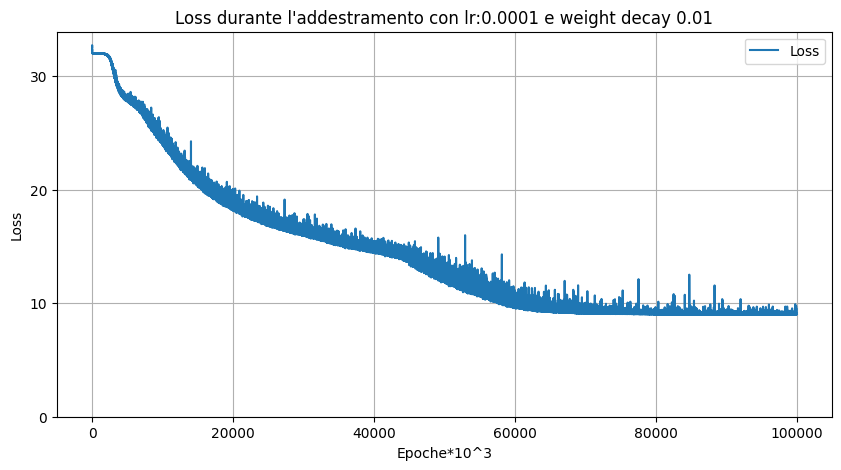

In [45]:
# Traccia il grafico della loss
from matplotlib import pyplot as plt
import math
#loss_vector_story_array= np.array(loss_vector_story)

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss durante l\'addestramento con lr:0.0001 e weight decay 0.01')
plt.xlabel('Epoche*10^3')
plt.ylabel('Loss')
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 10))
plt.legend()
plt.grid()
plt.show()

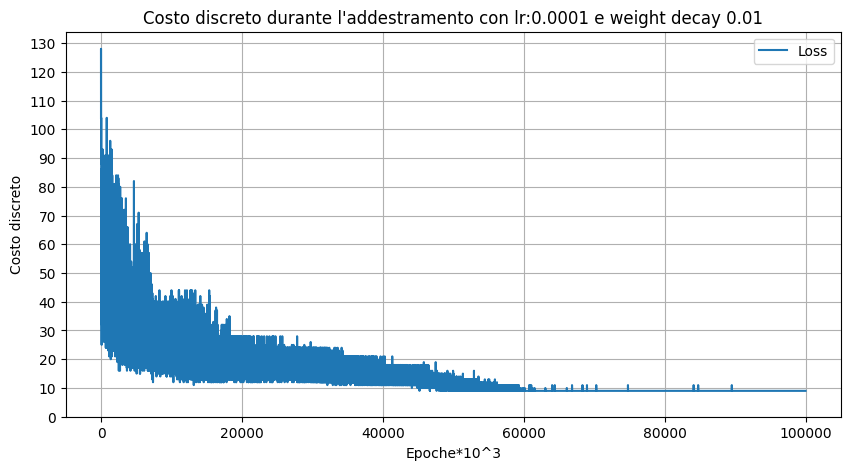

In [46]:
# Traccia il grafico della loss
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento con lr:0.0001 e weight decay 0.01')
plt.xlabel('Epoche*10^3')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 10))
plt.legend()
plt.grid()
plt.show()

In [47]:
# check for color violations
best_cost_hard = loss_func_color_hard(best_coloring, nx_graph)

print(f'Best (hard) cost of coloring (n_class={hypers["number_classes"]}): {best_cost_hard}')

# check for color violations
final_cost_hard = loss_func_color_hard(final_coloring, nx_graph)

print(f'FInal (hard) cost of coloring (n_class={hypers["number_classes"]}): {final_cost_hard}')

Best (hard) cost of coloring (n_class=5): 9
FInal (hard) cost of coloring (n_class=5): 9


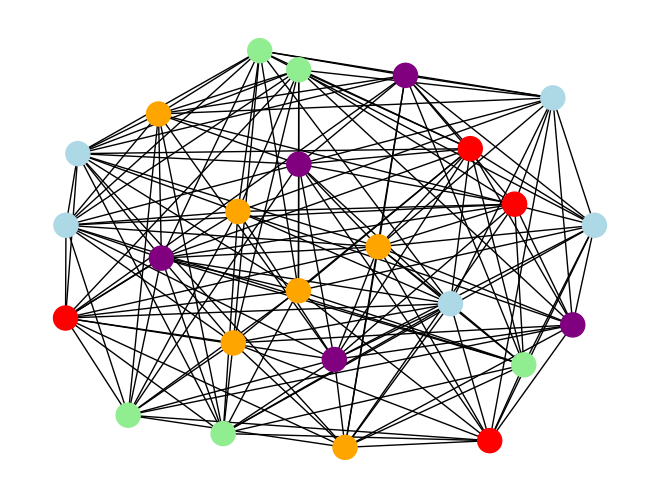

In [48]:
# Visualize result
color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen'}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

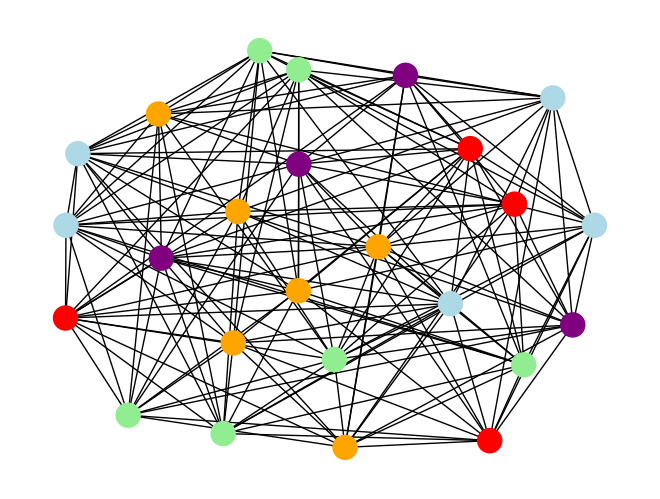

In [49]:
color_map2 = np.vectorize(color_dict.get)(final_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map2)

**da qua in poi procedimento senza epoche, solo per vedere una volta**

In [50]:
#inputs = embed.weight #ora non piu
#inputs.shape



logits=net(data)
probs = F.softmax(logits, dim=1)
print(probs.shape)

torch.Size([25, 5])


In [51]:
# get cost value with POTTS cost function
loss = loss_func_mod(probs, adj_)
print(loss)

tensor(9.0213, grad_fn=<DivBackward0>)


In [52]:
# get cost based on current hard class assignments
# update cost if applicable
coloring = torch.argmax(probs, dim=1)
cost_hard = loss_func_color_hard(coloring, nx_graph)
print(cost_hard)

tensor(9)


In [53]:
best_coloring=coloring

# Final coloring
final_loss = loss
final_coloring = torch.argmax(probs, 1)
print(f'Final coloring: {final_coloring}, soft loss: {final_loss}')

Final coloring: tensor([1, 0, 2, 4, 1, 4, 2, 1, 3, 0, 3, 1, 0, 2, 4, 0, 2, 3, 1, 4, 2, 4, 0, 0,
        3]), soft loss: 9.02133846282959


In [54]:
# check for color violations
best_cost_hard = loss_func_color_hard(best_coloring, nx_graph)

print(f'Best (hard) cost of coloring (n_class={hypers["number_classes"]}): {best_cost_hard}')

Best (hard) cost of coloring (n_class=5): 9


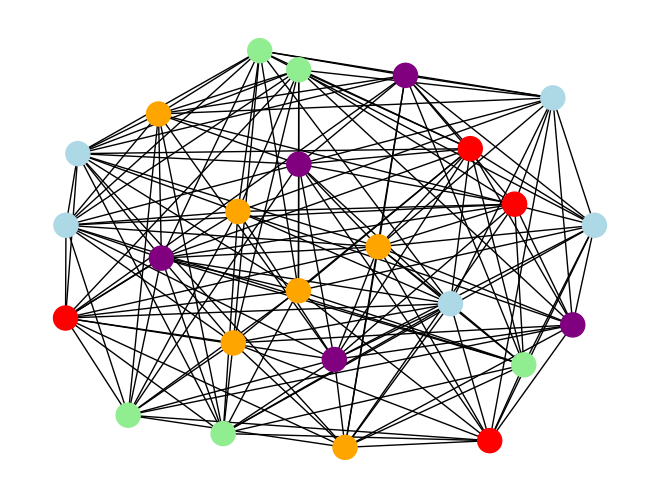

In [55]:
# Visualize result
color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen'}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

In [56]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

In [57]:
net = net.type(TORCH_DTYPE).to(TORCH_DEVICE)

In [58]:
print(net)

GNNConv(
  (conv1): GCNConv(64, 64)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(64, 5)
)


In [59]:
#NB. 'number_classes': chromatic_numbers[problem_file]   #qua 5

In [60]:
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 8.1e-05
    maximize: False
    weight_decay: 0.01
)


# Step 3 - Set up optimizer/GNN architecture

Instantiate optimizer and GNN objects with specified hypers.